In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gzip
from IPython import display

In [3]:
def vectorize_digit_labels(labels):
    '''name:         vectorize_digit_labels
       description:  function vectorizes the labels of digits (0-9), for example: 
                         0 == [1,0,0,0,0,0,0,0,0,0]
                         .
                         .
                         .
                         5 == [0,0,0,0,0,1,0,0,0,0]
                         .
                         .
                         .
                         9 == [0,0,0,0,0,0,0,0,0,1]
       dependencies: none
       inputs:       labels - N x 1 vector of digit (0-9) labels
       outputs:      labels_vectorized - N x 10 matrix of vectorized digits
    '''
    
    # get number of samples and number of unique labels
    samples = labels.shape[0]
    num_unique = unique(labels).shape[0]
    
    # create a matrix of unique vectos corresponding to unique labels
    unique_labels_vectorized = eye(num_unique)
    
    # create an empty matrix to store vectorized labels
    labels_vectorized = empty((samples, num_unique))
    
    # get vectorized version of labe for each sample
    for sample_idx in range(samples):
        
        # using label as index, because labels are digits (0-9)
        label_idx = labels[sample_idx].astype(int)
        
        # adding vectorized version to matrix of labels
        labels_vectorized[sample_idx] = unique_labels_vectorized[label_idx,:]
        
    # return vectorized labels
    return labels_vectorized

In [4]:
def pca(data, k_features):
    '''name:         pca
       description:  function takes an original data set an makes the following transformations: 
                     the data is centered about the origin; the covariance is then calculated; 
                     the eigenvalues and eigenvectors of the covariance are found; 
                     the original data is the projected onto the k eigenvectors in descending order 
                     of their eigenvalues, creating a new N x K matrix of k principal components
       dependencies: none
       inputs:       data - is an N x K matrix with the rows representing observations and columns representing features
                     k_features - is an integer representing the number of principal components or features to keep
       outputs:      reduced_data - an N x k_features matrix 
    '''
    
    # check 0 < k_features <= number of features
    if k_features > 0 and k_features <= data.shape[1]:

        # center the data and calculate the covariance matrix (sigma)
        sigma = corrcoef(data.T)

        # get the eigenvectors of sigma
        eigen_vecs, _, _ = linalg.svd(sigma)

        # create an empty matrix to hold dimensionally reduced data
        reduced_data = empty((data.shape[0], k_features))

        # for each observation x, project x onto eigenvectors
        for observation_idx in range(data.shape[0]):
            reduced_data[observation_idx] = dot(eigen_vecs[:,:k_features].T, data[observation_idx,:][:,newaxis])[:,newaxis].T

        # return dimensionally reduced data
        return reduced_data
    
    # print error message
    print ('ERROR: 0 < k_features < %i') % data.shape[1]

In [5]:
def delta_bar_delta(gamma, nabla_E, delta, up=0.1, down=0.1, phi=0.01):
    '''name:         delta_bar_delta
       description:  step size (gamma) is increased whenever the algorithm proceeds down the error function
                     step size (gamma) is decreased when the algorithm jumps over a valley of the error function
       dependencies: none
       inputs:       gamma - vector of step sizes
                     nabla_E - matrix of gradient errors
                     delta - vector of exponentially averaged partial derivative in the direction of weight
       outputs:      gamma - vector of step sizes
                     delta_new - updated delta
    '''
    
    # caculate sum of gradient error
    nabla_E_sum = sum(nabla_E, axis=1)[:,newaxis]
    
    # caculate new delta
    delta_new = (1 - phi) * nabla_E_sum + phi * delta
    
    # update each gamma
    for idx in range(gamma.shape[0]):
        
        # if gradient is on same side, from previous, increase the step size
        if nabla_E_sum[idx] * delta[idx] > 0: gamma[idx] + up
        
        # if gradient is on opposite side, form previous, increase the step size
        elif nabla_E_sum[idx] * delta[idx] < 0: gamma[idx] * down
            
        # otherwise do nothing
        else: pass
            
    # return modified gamma and new delta
    return gamma, delta_new

In [6]:
def single_hidden_train(data, labels, num_features=None, k_units=20, iterations=750, output_graph=False):
    '''name:         single_hidden_train
       description:  function learns the weights of a single hidden layer neural network 
                     using a back propagation algorithm defined as:
                         1. Feed-forward computation
                         2. Backpropagation to the output layer
                         3. Backpropagation to the hidden layer
                         4. Weight updates using gradient descent
                     in addition, the function dispalys a plot of the error verses the number of
                     iterations; at this point the user may decide to continue the training or
                     exit the function
       dependencies: delta_bar_delta
       inputs:       data - an N x K matrix with the rows representing observations and columns representing features
                     labels - matrix of vectorized labels
                     num_features - PCA is used to reduce the number of features, by default data is not reduced
                     k_units - number of hidden units
                     iterations - number of times the weights are updated 
                     output_graph - allows user to perform another round of iterations based on a graph of the error
       outputs:      W_1 - trained weights for input layer
                     W_2 - trained weights for output of hidden layer
                     error_rate - final error rate of training data
    '''
    
    # check if dimensionality is to be reduced
    if num_features: data = pca(data, num_features)
    
    # get number of samples, features, and outputs
    x_samples = data.shape[0]
    n_features = data.shape[1]
    m_outputs = labels.shape[1]
    
    # intialize initial vectors of weights, with bias term added to last row
    W_1_bar = random.uniform(0.01, 0.1, (n_features + 1, k_units)) # (N + 1) x K
    W_2_bar = random.uniform(0.01, 0.1, (k_units + 1, m_outputs)) # (K + 1) x M
    
    # define node functions sigmoid and sigmoid_prime
    sigmoid = lambda vec_x: 1 / (1 + exp(-vec_x))
    sigmoid_prime = lambda vec_x: sigmoid(vec_x) * (1 - sigmoid(vec_x))
    
    # define error function
    error_func = lambda vec_e: 0.5 * vec_e**2
    
    # define initial gradient step sizes and deltas to be used in delta_bar_delta
    gamma_1 = random.uniform(0.01, 0.1, (k_units, 1)) # K x 1
    bar_delta_1 = zeros((k_units, 1)) # K x 1
    gamma_2 = random.uniform(0.01, 0.1, (m_outputs, 1)) # M x 1
    bar_delta_2 = zeros((m_outputs, 1)) # M x 1
    
    # define offset and create arrays to store sample error & sum of errors
    offset = 0
    sample_error = zeros((x_samples,1))
    sum_of_errors = zeros((iterations,1))
    
    # while user chooses to continue
    iterate = True
    while iterate:
        
        # iterate for specified number of steps
        for iteration in range(iterations):
            
            # loop through each sample
            for sample_idx in range(x_samples):

                # --------------------------------------------------------------------------------
                # step one: feed-forward computation
                # --------------------------------------------------------------------------------

                # get input vector which, for consistancy, we will call output_0 and add bias term
                output_0 = data[sample_idx,:][newaxis,:] # 1 x N
                output_0_hat = hstack((output_0, ones((1, 1)))) # 1 x (N + 1)
                
                # caculate output_1 and add bias term
                output_1 = sigmoid(dot(output_0_hat, W_1_bar)) # 1 x K
                output_1_hat = hstack((output_1, ones((1, 1)))) # 1 x (K + 1)
                
                # caculate output_2 and convert to vectorized label
                output_2 = sigmoid(dot(output_1_hat, W_2_bar)) # 1 x M
                new_output_2 = zeros(output_2.shape)
                new_output_2[:,argmax(output_2)] = 1
                
                # caculate derivatives of output_1 and output_2 and store in diagonal matrices
                D_1 = diagflat(sigmoid_prime(dot(output_0_hat, W_1_bar))) # K x K
                D_2 = diagflat(sigmoid_prime(dot(output_1_hat, W_2_bar))) # M x M
                
                # caculate difference in error
                error_diff = new_output_2 - labels[sample_idx,:][newaxis,:] # 1 x M
                
                # caculate sum of the sample's error
                sample_error[sample_idx] = sum(error_func(error_diff))
                
                # --------------------------------------------------------------------------------
                # step two: backpropagation to the output layer
                # --------------------------------------------------------------------------------

                # define backpropagated error of output layer
                delta_2 = dot(D_2, error_diff.T) # M x 1
                
                # define error gradient of output layer
                nabla_E_2 = dot(delta_2, output_1_hat) # M x (K + 1)
                
                # --------------------------------------------------------------------------------
                # step three: backpropagation to the hidden layer
                # --------------------------------------------------------------------------------

                # define backpropagated error of hidden layer
                delta_1 = dot(D_1, dot(W_2_bar[:-1,:], delta_2)) # K x 1
                
                # define error gradient of hidden layer
                nabla_E_1 = dot(delta_1, output_0_hat) # K x (N + 1)
                
                # --------------------------------------------------------------------------------
                # step four: weight updates
                # --------------------------------------------------------------------------------

                # get gamma_1 and gamma_2 using delta-bar-delta
                gamma_1, bar_delta_1 = delta_bar_delta(gamma_1, nabla_E_1, bar_delta_1)
                gamma_2, bar_delta_2 = delta_bar_delta(gamma_2, nabla_E_2, bar_delta_2)
                
                # update weights
                W_1_bar += (-gamma_1 * nabla_E_1).T # (N + 1) x K
                W_2_bar += (-gamma_2 * nabla_E_2).T # (K + 1) x M
                
            # add all sample errors to sum of errors
            sum_of_errors[iteration + offset] = sum(sample_error) / x_samples
        
        # output a graph and let the user decide to continue or not
        if output_graph:
            
            # output graph of error vs. steps
            plot(sum_of_errors)
            xlim([0,sum_of_errors.shape[0]-1])
            ylim([0,sum_of_errors[argmax(sum_of_errors)]])
            xlabel('Number of Iterations')
            ylabel('Sum of Error (%)')
            title_str = ('3 Layer NN w/ %i Hidden Units at %i Iterations') % (k_units, iterations)
            title(title_str)
            display.clear_output(wait=True)
            display.display(show())

            # output prompt to continue or exit
            response = raw_input('Continue training neural network ([y]/n)? ')
            if response.lower() != 'n': 
                offset += iterations
                sum_of_errors = vstack((sum_of_errors, zeros((iterations,1))))
            else: iterate = False
                
        # else continue iterating till 
        else: iterate = False

    # return weights with bias row removed and associated error rate
    return W_1_bar[:-1,:], W_2_bar[:-1,:], (sum(sample_error) / x_samples)

In [19]:
def single_hidden_predict(data, m_outputs, weight_1, weight_2, k_units=20):
    '''name:         single_hidden_predict
       description:  functions uses previously trained weights to predict the output of a given data set
       dependencies: none
       inputs:       data - an N x K matrix with the rows representing observations and columns representing features
                     m_outputs - number of possiable labeles
                     weight_1 - trained weights for input layer
                     weight_2 - trained weights for output layer
                     k_units - number of hidden units
       outputs:      y_hat - vector of predicted labels
    '''
    
    # get number of samples
    x_samples = data.shape[0]
    
    # define node function sigmoid
    sigmoid = lambda vec_x: 1 / (1 + exp(-vec_x))
    
    # initialize vector for labels
    labels = empty((x_samples,1))
    
    # loop through each observation
    for sample_idx in range(x_samples):
    
        # get input vector, call it output zero for consistency 
        output_0 = data[sample_idx,:][newaxis,:]
        
        # caculate output one
        output_1 = sigmoid(dot(output_0, weight_1))
        
        # caculate output two
        output_2 = sigmoid(dot(output_1, weight_2))
        
        # convert output two to a single digit label and to array of labels
        labels[sample_idx] = argmax(output_2)
        
    # return predicted labels
    return labels

In [41]:
def confusion_matrix(y, y_hat):
    '''name:         confusion_matrix
       description:  function displays a matrix of true positives and false positives
       dependencies: none
       inputs:       y - actual labels
                     y_hat - predicted labels
       outputs:      none
    '''
    
    # convert y's as integer arrays
    y = y.astype(int)
    y_hat = y_hat.astype(int)
    
    # get the quantity of unique labels
    num_labels = unique(y).shape[0]
    
    # initilize confusion matrix and label quantity vector
    confusion_mat = zeros((num_labels, num_labels))
    label_quantities = zeros(num_labels)
    
    # for each observed / predicted label, 
    for idx in range(y.shape[0]):
        
        # add 1 to the corresponding cell
        confusion_mat[y[idx], y_hat[idx]] += 1
        
    # get quantity of each actual label
    for label in range(num_labels):
        label_quantities[label] = y[y[:] == label].shape[0]
        
    # print confusion matrix
    print divide(confusion_mat, label_quantities[:,newaxis]).round(2)

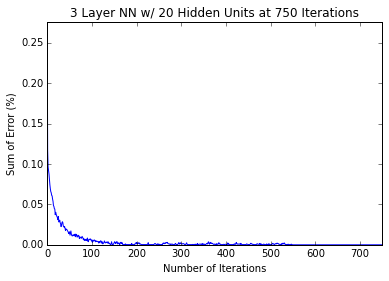

None

Continue training neural network ([y]/n)? n


In [9]:
# get the training data from file
with gzip.open('../Data/zip.train.gz') as f:
    train = loadtxt(f)
    
# separate the observations from the labels and vectorize the labels
X_train = train[:,1:]
y_train = vectorize_digit_labels(train[:,0][:,newaxis])

# train weights and get error rate
W_1, W_2, error_rate = single_hidden_train(X_train, y_train, num_features=X_train.shape[1]-1, output_graph=True)

In [42]:
# get the test data 
with gzip.open('../Data/zip.test.gz') as f:
    test = loadtxt(f)
    
# separate the observations from the labels
X_test = test[:,1:]
y_test = test[:,0][:,newaxis]

# reduce the number of features to optimal dimensions
X_test = pca(X_test, X_test.shape[1]-1)

# make predictions 
y_hat = single_hidden_predict(X_test, unique(y_test).shape[0], W_1, W_2)

# output confusion matrix
confusion_matrix(y_test, y_hat)

[[ 0.82  0.03  0.04  0.    0.    0.08  0.01  0.    0.02  0.  ]
 [ 0.    0.95  0.01  0.    0.    0.02  0.    0.02  0.    0.  ]
 [ 0.08  0.06  0.73  0.01  0.03  0.04  0.01  0.05  0.01  0.02]
 [ 0.13  0.09  0.14  0.27  0.    0.34  0.02  0.02  0.01  0.  ]
 [ 0.04  0.07  0.02  0.    0.02  0.24  0.01  0.16  0.08  0.36]
 [ 0.05  0.26  0.08  0.01  0.    0.44  0.09  0.03  0.03  0.  ]
 [ 0.11  0.03  0.28  0.    0.    0.04  0.54  0.01  0.01  0.01]
 [ 0.    0.01  0.01  0.    0.    0.03  0.    0.91  0.02  0.01]
 [ 0.01  0.06  0.16  0.    0.01  0.27  0.04  0.02  0.39  0.04]
 [ 0.01  0.05  0.01  0.02  0.    0.22  0.    0.14  0.19  0.37]]
